In [2]:
import mne
import numpy as np
import os
from pathlib import Path
from EEG_quality_assessment.signal_metrics import SignalMetrics
import asrpy
import pyprep
import shutil

from eeg_fmri_cleaning.utils import read_raw_eeg
from eeg_fmri_cleaning.main import (
    clean_gradient,
    clean_bcg
)
import bids
from bids.layout import BIDSLayout, BIDSFile

In [3]:
f = BIDSFile('projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW/sub-01/ses-01/eeg/sub-01_ses-01_task-rest_eeg.fif')

In [8]:
import os
import tempfile
import json



Temporary BIDS dataset created at /var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpem394tqi


In [12]:
from bids import BIDSLayout

# Initialize a BIDS Layout with the path of the temp BIDS directory
layout = BIDSLayout(temp_bids_path, validate=True)

# Example operation: get BIDS entities
e = layout.get_entities()

In [16]:
def create_temp_bids_eeg(n_subjects: int = 1, n_sessions: int = 1, n_runs: int = 1):
    """
    Create a dummy BIDS dataset for EEG data with multiple subjects, sessions, and runs.

    Args:
        n_subjects (int, optional): Number of subjects to create. Defaults to 1.
        n_sessions (int, optional): Number of sessions per subject. Defaults to 1.
        n_runs (int, optional): Number of runs per session. Defaults to 1.

    Returns:
        str: The path of the temporary BIDS dataset.
    """
    # Create a temporary directory for the BIDS dataset
    temp_dir = tempfile.mkdtemp()

    # Define the necessary BIDS files for dataset description
    dataset_description = {
        "Name": "THIS IS A DUMMY DATASET",
        "BIDSVersion": "1.4.0",
        "License": "CC0",
        "Authors": ["Jane Doe", "John Doe"]
    }

    # Write dataset_description.json
    with open(os.path.join(temp_dir, "dataset_description.json"), 'w') as desc_file:
        json.dump(dataset_description, desc_file, indent=4)

    # Initialize participants data
    participants_data = "participant_id\tage\n"

    # Generate subjects, sessions, and runs
    for sub_id in range(1, n_subjects + 1):
        subject_label = f"sub-{sub_id:02d}"
        participants_data += f"{subject_label}\t{20 + sub_id}\n"  # Just example ages

        for ses_id in range(1, n_sessions + 1):
            session_label = f"ses-{ses_id:02d}"
            
            for run_id in range(1, n_runs + 1):
                run_label = f"run-{run_id:02d}"
                eeg_dir = os.path.join(temp_dir, subject_label, session_label, "eeg")
                os.makedirs(eeg_dir, exist_ok=True)  # Create necessary directories

                # Define file names for EEG data files
                eeg_filenames = [
                    f"{subject_label}_{session_label}_task-test_{run_label}_eeg.vhdr",
                    f"{subject_label}_{session_label}_task-test_{run_label}_eeg.eeg",
                    f"{subject_label}_{session_label}_task-test_{run_label}_eeg.vmrk"
                ]

                # Create dummy EEG files
                for eeg_file in eeg_filenames:
                    with open(os.path.join(eeg_dir, eeg_file), 'w') as file:
                        file.write("Dummy EEG file content\n")

    # Write participants.tsv
    with open(os.path.join(temp_dir, "participants.tsv"), 'w') as part_file:
        part_file.write(participants_data)

    print(f"Temporary BIDS dataset created at {temp_dir}")
    return temp_dir
temp_dir = create_temp_bids_eeg(n_subjects=2, n_sessions=2, n_runs=2)

Temporary BIDS dataset created at /var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24


In [20]:
temp_dir

'/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24'

In [17]:

layout = BIDSLayout(temp_dir)

In [19]:
layout.get_files()

{'/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/dataset_description.json': <BIDSJSONFile filename='/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/dataset_description.json'>,
 '/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/participants.tsv': <BIDSDataFile filename='/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/participants.tsv'>,
 '/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/sub-01/ses-02/eeg/sub-01_ses-02_task-test_run-01_eeg.eeg': <BIDSFile filename='/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/sub-01/ses-02/eeg/sub-01_ses-02_task-test_run-01_eeg.eeg'>,
 '/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/sub-01/ses-02/eeg/sub-01_ses-02_task-test_run-02_eeg.eeg': <BIDSFile filename='/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/sub-01/ses-02/eeg/sub-01_ses-02_task-test_run-02_eeg.eeg'>,
 '/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpw7753x24/sub-01/ses-02/eeg/sub

In [22]:
a_list = list()
a_list.append("GRAD")
print(a_list)
len(a_list)

['GRAD']


1

In [8]:
from utils import dummy_bids
from bids.layout import BIDSLayout
dummy = dummy_bids.DummyDataset(n_runs = 2)
dummy.create_eeg_dataset()
layout = BIDSLayout(dummy.bids_path)
files = layout.get(extension='.vhdr')
#dummy.flush(check=False)

Temporary BIDS dataset created at /var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmpuq4l5t08/RAW


In [13]:
import mne
info = mne.create_info(32, 1000)
raw = mne.simulation.simulate_raw(info)
raw.plot()

ValueError: src must be a string or instance of SourceSpaces, got None (type <class 'NoneType'>)

In [7]:
dummy.flush(check=False)

Removing the temporary directory...
Content being removed:
/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/tmp8tvysj1_/
└── RAW/
    ├── sub-01/
    │   └── ses-01/
    │       └── eeg/
    │           ├── sub-01_ses-01_task-test_run-01_eeg.eeg
    │           ├── sub-01_ses-01_task-test_run-01_eeg.json
    │           ├── sub-01_ses-01_task-test_run-01_eeg.vhdr
    │           ├── sub-01_ses-01_task-test_run-01_eeg.vmrk
    │           ├── sub-01_ses-01_task-test_run-02_eeg.eeg
    │           ├── sub-01_ses-01_task-test_run-02_eeg.json
    │           ├── sub-01_ses-01_task-test_run-02_eeg.vhdr
    │           └── sub-01_ses-01_task-test_run-02_eeg.vmrk
    ├── dataset_description.json
    └── participants.tsv
The tree was successfully removed.


In [4]:
import utils.simulated_data as sim

In [6]:
sim.DirectoryTree()

TypeError: DirectoryTree.__init__() missing 1 required positional argument: 'root_dir'

In [38]:
l = list(layout.get_files())

In [1]:
a = {'a':1, 'b':2}
for i in a:
    print(i)

a
b


In [30]:
from pathlib import Path
import os
filename = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW/sub-01/ses-01/eeg/sub-01_ses-01_task-rest_eeg.fif')
os.path.splitext(filename)

('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW/sub-01/ses-01/eeg/sub-01_ses-01_task-rest_eeg',
 '.fif')

In [19]:
import bids
filename = 'sub-01_ses-01_task-rest_eeg.fif'
file = bids.utils.make_bidsfile('sub-01_ses-01_task-rest_eeg.fif')

In [15]:
bids.layout.parse_file_entities(file)

{'session': '01', 'task': 'rest', 'suffix': 'eeg', 'extension': ".fif'>"}

In [21]:
test = bids.layout.BIDSFile(filename)

In [10]:
import mne
import numpy as np
base_filename = 'sub-01_ses-01_task-rest_eeg.set'
random_data = np.random.rand(32, 1000)
ch_names = [f'EEG {i}' for i in range(32)]
info = mne.create_info(ch_names, 1000)
raw = mne.io.RawArray(random_data, info)
mne.export.export_raw(base_filename, raw, fmt='eeglab', overwrite=True)

Creating RawArray with float64 data, n_channels=32, n_times=1000
    Range : 0 ... 999 =      0.000 ...     0.999 secs
Ready.


In [4]:
import pybv
data = np.random.random((3, 5))
# write data with varying units
# Note channels A1 and A2 are expected to be in volt and will get
# rescaled to µV and mV respectively.
# TEMP is expected to be in some other unit (i.e., NOT volt), and
# will not get scaled (it is written "as is")
pybv.write_brainvision(data=data, sfreq=1, ch_names=["A1", "A2", "TEMP"],
                       folder_out="./",
                  fname_base="pybv_test_file",
                  unit=["µV", "mV", "°C"])

/opt/anaconda3/envs/mne/lib/python3.12/site-packages/pybv/io.py:681: UserWarning: Encountered unsupported voltage units: mV
We will scale the data appropriately, but for maximum compatibility you should use µV for all channels.
  warn(msg)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/pybv/io.py:690: UserWarning: Encountered unsupported non-voltage units: °C
Note that the BrainVision format specification supports only µV.
  warn(msg)


In [11]:
a = ['a','b','c']
b = [False, True, False]
print(a[b])

TypeError: list indices must be integers or slices, not list

In [25]:
os.path.isfile(filename_base + '.json')

True

In [31]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne import Epochs, compute_covariance, find_events, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (
    add_ecg,
    add_eog,
    add_noise,
    simulate_raw,
    simulate_sparse_stc,
)

print(__doc__)

data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)

Automatically created module for IPython interactive environment
Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 984GB/s]
Untarring contents of '/Users/samuel/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/samuel/mne_data'


Download complete in 02m20s (1576.2 MB)
Opening raw data file /Users/samuel/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


Reading forward solution from /Users/samuel/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


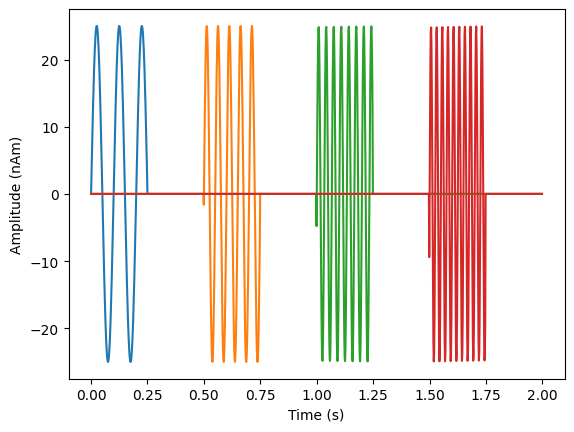

In [32]:
n_dipoles = 4  # number of dipoles to create
epoch_duration = 2.0  # duration of each epoch/event
n = 0  # harmonic number
rng = np.random.RandomState(0)  # random state (make reproducible)


def data_fun(times):
    """Generate time-staggered sinusoids at harmonics of 10Hz."""
    global n
    n_samp = len(times)
    window = np.zeros(n_samp)
    start, stop = [
        int(ii * float(n_samp) / (2 * n_dipoles)) for ii in (2 * n, 2 * n + 1)
    ]
    window[start:stop] = 1.0
    n += 1
    data = 25e-9 * np.sin(2.0 * np.pi * 10.0 * n * times)
    data *= window
    return data


times = raw.times[: int(raw.info["sfreq"] * epoch_duration)]
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]
stc = simulate_sparse_stc(
    src, n_dipoles=n_dipoles, times=times, data_fun=data_fun, random_state=rng
)
# look at our source data
fig, ax = plt.subplots(1)
ax.plot(times, 1e9 * stc.data.T)
ax.set(ylabel="Amplitude (nAm)", xlabel="Time (s)")
mne.viz.utils.plt_show()

In [30]:
raw_sim = simulate_raw(raw.info, [stc] * 10, forward=fwd, verbose=True)
cov = make_ad_hoc_cov(raw_sim.info)
add_noise(raw_sim, cov, iir_filter=[0.2, -0.2, 0.04], random_state=rng)
add_ecg(raw_sim, random_state=rng)
add_eog(raw_sim, random_state=rng)
raw_sim.plot()

NameError: name 'simulate_raw' is not defined

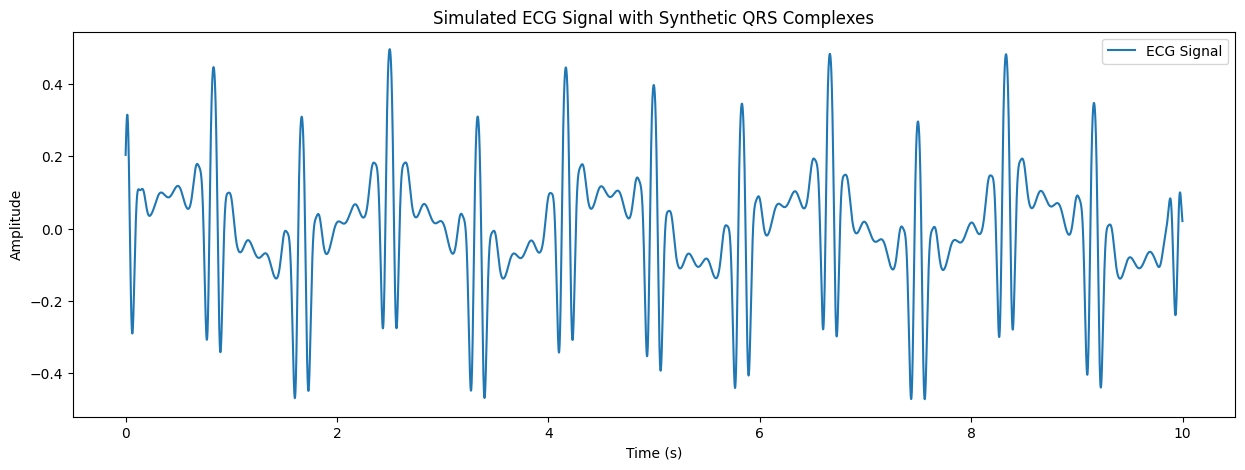

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, butter, filtfilt, find_peaks

# Parameters
fs = 1000  # Sampling frequency in Hz
duration = 10  # Duration in seconds
f_heart = 1.2  # Heartbeat frequency in Hz (approximately 72 beats per minute)
t = np.linspace(0, duration, int(duration * fs), endpoint=False)  # Time variable

# Generate a basic signal with cardiac frequency: simple harmonic motion to simulate the baseline
base_signal = 0.1 * np.sin(2 * np.pi * 0.5 * t)  # Base sinusoidal signal for baseline wander

# Generate synthetic QRS complexes
qrs_duration = 0.08  # Rough duration of QRS complex in seconds
qrs_peaks = np.arange(0, len(t), int(fs/f_heart))  # Approximate indices at which QRS complexes occur
qrs_data = np.zeros_like(t)
qrs_width = int(qrs_duration * fs)  # Width of the QRS complex in terms of number of samples
for peak in qrs_peaks:
    start = max(0, peak - qrs_width // 2)
    end = min(len(t), peak + qrs_width // 2)
    qrs_data[start:end] = 1.0  # Assign amplitude

# Design a Butterworth bandpass filter to shape the QRS complex
b, a = butter(3, [5/(0.5*fs), 15/(0.5*fs)], btype='band')
filtered_qrs = filtfilt(b, a, qrs_data)  # Apply the filter to the rectangular pulses

# Combine the baseline and QRS data
ecg_signal = base_signal + filtered_qrs

# Plot the final ECG signal
plt.figure(figsize=(15, 5))
plt.plot(t, ecg_signal, label='ECG Signal')
plt.title('Simulated ECG Signal with Synthetic QRS Complexes')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


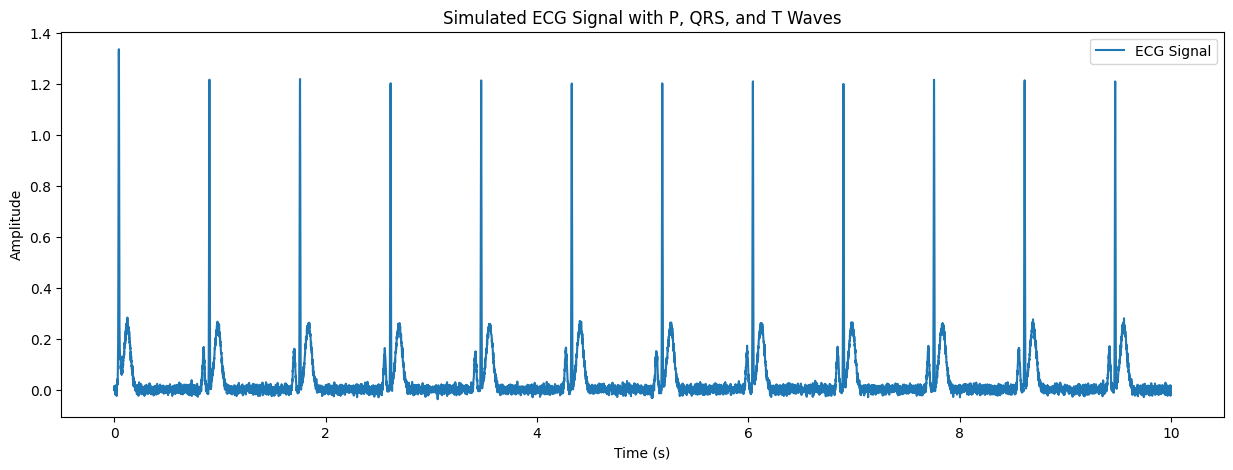

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal.windows import gaussian

def generate_ecg_waveform(fs, duration, heart_rate):
    num_samples = int(duration * fs)
    t = np.linspace(0, duration, num_samples, endpoint=False)  # Time vector
    
    # Heartbeat locations
    beats_per_second = heart_rate / 60.0
    beat_samples = int(fs / beats_per_second)
    r_peaks = np.arange(0, num_samples, beat_samples)
    
    # Initialize ECG signal
    ecg_signal = np.zeros(num_samples)
    
    # P wave parameters
    p_wave_duration = int(0.1 * fs)
    p_wave = gaussian(p_wave_duration, std=10) * 0.15  # P wave is a small bump
    
    # QRS complex parameters
    qrs_duration = int(0.09 * fs)  # Slightly longer to avoid shape issues
    qrs_wave = gaussian(qrs_duration, std=3)  # Gaussian for QRS shape
    qrs_wave = (qrs_wave / max(qrs_wave)) * 1.2  # Normalize and scale the QRS complex
    
    # T wave parameters
    t_wave_duration = int(0.16 * fs)  # Adjust duration to fit within beat samples
    t_wave = gaussian(t_wave_duration, std=30) * 0.25  # T wave is a larger bump
    
    # Construct the ECG signal by adding P, QRS, and T waves centered at the r_peaks
    for peak in r_peaks:
        # Add P wave
        start = int(max(peak - p_wave_duration * 0.6, 0))
        end = int(min(start + p_wave_duration, num_samples))
        ecg_signal[start:end] += p_wave[:end-start]
        
        # Add QRS complex
        start = int(max(peak, 0))
        end = int(min(start + qrs_duration, num_samples))
        ecg_signal[start:end] += qrs_wave[:end-start]
        
        # Add T wave
        start = int(max(peak + qrs_duration * 0.5, 0))  # Start T wave after QRS
        end = int(min(start + t_wave_duration, num_samples))
        ecg_signal[start:end] += t_wave[:end-start]
    
    # Add noise
    noise = np.random.normal(0, 0.01, num_samples)
    ecg_signal += noise
    
    return t, ecg_signal

# Parameters
fs = 1000  # Sampling frequency (samples per second)
duration = 10  # Duration of the signal in seconds
heart_rate = 70  # Average heart rate in beats per minute

t, ecg_signal = generate_ecg_waveform(fs, duration, heart_rate)

# Plot the final ECG signal
plt.figure(figsize=(15, 5))
plt.plot(t, ecg_signal, label='ECG Signal')
plt.title('Simulated ECG Signal with P, QRS, and T Waves')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

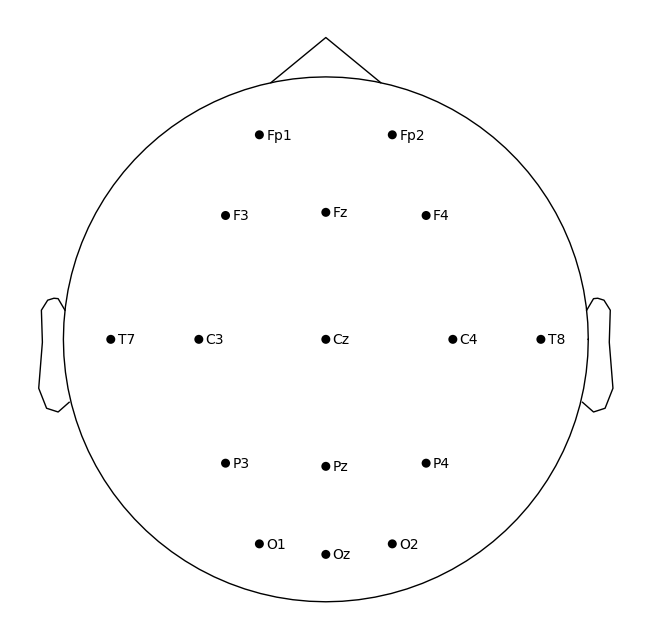

In [13]:
import mne
montage = mne.channels.make_standard_montage('biosemi16')
montage.plot()

In [21]:
%matplotlib qt
import neurokit2 as nk
from matplotlib import pyplot as plt
ecg = nk.ecg_simulate(duration=6, noise=0.1, heart_rate=70, sampling_rate=256, random_state=None)
sig = nk.eeg_simulate(duration=6, length=None, sampling_rate=256, noise=0.1, random_state=None)
plt.subplot(3,1,1)
plt.plot(sig)
plt.title('EEG Signal')
plt.subplot(3,1,2)
plt.plot(ecg)
plt.title('ECG Signal')
plt.subplot(3,1,3)
plt.plot(sig + (ecg*3) * 1e-6)
plt.title('EEG + ECG Signal')

Text(0.5, 1.0, 'EEG + ECG Signal')

In [28]:
import numpy as np
a = np.zeros((10,sig.shape[0]))
a[0,:] = sig

In [2]:
import mne
montage = mne.channels.make_standard_montage('biosemi16')
ch_names = montage.ch_names
info = mne.create_info(ch_names, 256, ch_types='eeg')

In [4]:
import mne
import numpy as np
montage = mne.channels.make_standard_montage('biosemi16')
eeg_data = np.random.rand(16, 1000)
ch_names = montage.ch_names
info = mne.create_info(ch_names, 256, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
ecg_data = np.random.rand(1, 1000)
ecg_info = mne.create_info(['ECG'], 256, ch_types='ecg')
ecg_raw = mne.io.RawArray(ecg_data, ecg_info)
raw.add_channels([ecg_raw])
raw.info['ch_names']

Creating RawArray with float64 data, n_channels=16, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.


['Fp1',
 'Fp2',
 'F4',
 'Fz',
 'F3',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'P4',
 'Pz',
 'P3',
 'O1',
 'Oz',
 'O2',
 'ECG']

In [9]:
mne.channels.get_builtin_montages()

['standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'biosemi16',
 'biosemi32',
 'biosemi64',
 'biosemi128',
 'biosemi160',
 'biosemi256',
 'easycap-M1',
 'easycap-M10',
 'easycap-M43',
 'EGI_256',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'mgh60',
 'mgh70',
 'artinis-octamon',
 'artinis-brite23',
 'brainproducts-RNP-BA-128']

In [1]:
a = [1,2,3]
a.insert(0,None)

In [2]:
a

[None, 1, 2, 3]

In [4]:
class Test:
    def __init__(self,
                 a: int = 1,
                 b: str = 'a'):
        print(locals().items())

c = Test()

dict_items([('self', <__main__.Test object at 0x105caac90>), ('a', 1), ('b', 'a')])


In [ ]:
file_list = layout.get(subject='01', 
           extension='set')
derivative_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES')

def is_task_checker(BIDSFile):
    return 'checker' in BIDSFile.get_entities()['task']

def report(message, filename):
    with open(filename, 'a') as f:
        f.write(message)
        f.write('\n')

def cbin_cleaner(file):
    raw = read_raw_eeg(file.path)
    if file.get_entities()['task'] == 'checker':
        raw = clean_gradient(raw)
    raw = clean_bcg(raw)
    return raw

def asr_cleaner(raw):
    asr = asrpy.ASR()
    asr.fit(raw)
    raw = asr.transform(raw)
    return raw

def copy_sidecar(file, where_to_copy):
    filename_base, filename_extension = os.path.splitext(file.path)
    sidecar_filename = filename_base + '.json'
    if os.path.isfile(sidecar_filename):
        shutil.copyfile(sidecar_filename, where_to_copy)
     
def make_directory(file, derivative_path):
    entities = bids.layout.parse_file_entities(file)
    file_path = Path(derivative_path)
    file_path.joinpath(entities['subject'],
                       entities['session'],
                       entities['datatype'])
    file_path.mkdir(parents=True, exist_ok=True)
    
def pyprep_cleaner(raw):
    montage = mne.channels.make_standard_montage('easycap-M10')
    raw.apply_montage(montage)
    prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(60, raw.info["sfreq"]/ 2, 60),
    }
    prep = pyprep.PrepPipeline(raw,
                               prep_params, 
                               channel_wise=True)
    prep.fit()
    raw = prep.transform(raw)
    return raw
        

In [ ]:
for file in file_list:
    if is_task_checker(file):
        try:
            raw = cbin_cleaner(file)
            
            
            pyprep_cleaner(raw)
            asr_cleaner(raw)
            report(file.path,
                f"{derivative_path}/processed.txt")
        except Exception as e:
            report(f"{file.path}: {str(e)}", 
                f"{derivative_path}/not_processed.txt")
            continue

In [3]:
a = (1,2)
try:
    a[0] = 3
except Exception as e:
    print(e)

'tuple' object does not support item assignment
